# Question 3: Dejounte Murray and Trae Young Usage Rates post Murray Trade


When looking at the dynamic of Dejounte Murray's impact to the Atlanta Hawks, this trade definitely turned some heads, so lets dive into this

First and foremost, Usage Rate is defined as 

as found on NBAstuffer

USG = (FGA + Turnovers + 0.44 * FTA) * 100 / (Total Team Possessions) 


lets first filter our data to include data with The Hawks or Spurs


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('nba_data_modeling_engineer.csv')

In [4]:

# Identify relevant team and player columns
team_columns = df.columns[df.columns.str.contains("Team", case=False)]
player_columns = df.columns[df.columns.str.contains("namePlayer", case=False)]

# Filter for rows where any of the team columns contain 'ATL' (Hawks) or 'SAS' (Spurs)
team_filter = (
    df[team_columns]
    .apply(
        lambda col: col.astype(str).str.contains("ATL")
        | col.astype(str).str.contains("SAS"),
        axis=0,
    )
    .any(axis=1)
)


event_filter = (
    df["numberEvent"] > 2
)

# Apply combined filters
filtered_df = df[team_filter & event_filter]

Following the Usage rate formula we need to calculate the usage rates of each of the necessary stats 
- FGA 
- TO 
- FTA 
- Total Team Posessions 

Lets do this one player at a time, the following is for Trae Young: 

Lets start with getting his information in calculating USG 

In [5]:
trae_young_games = filtered_df[
    (filtered_df["namePlayer1"].str.contains("Trae Young", case=False, na=False))
    | (filtered_df["namePlayer2"].str.contains("Trae Young", case=False, na=False))
]["idGame"].unique()

# We only care about Trae Youngs games for Traes usage rate
filtered_trae_df = filtered_df[filtered_df["idGame"].isin(trae_young_games)]

# Filter for Hawks games where Trae played
filtered_hawks_trae_df = filtered_trae_df[
    filtered_df["slugTeamPlayer1"].str.contains("ATL", case=False, na=False)
]

# Filter for Trae Specific stats
trae_df = filtered_hawks_trae_df[
    filtered_hawks_trae_df["namePlayer1"].str.contains(
        "Trae Young", case=False, na=False
    )
]
# Lets Find Traes stats for usage rate
trae_young_shots_attempted = trae_df[
    trae_df["numberEventMessageType"].isin([1, 2])
]

trae_young_turnovers = trae_df[trae_df["numberEventMessageType"] == 5]

trae_young_free_throws = trae_df[trae_df["numberEventMessageType"] == 3]

# lets now find the total of all team posessions

hawks_shot_attempted = filtered_hawks_trae_df[
    filtered_hawks_trae_df["numberEventMessageType"].isin([1, 2])
]
# Total turnovers for the Hawks (Event Type 8)
hawks_turnovers = filtered_hawks_trae_df[
    filtered_hawks_trae_df["numberEventMessageType"] == 5
]


# Total free throws for the Hawks (Event Type 3)
hawks_free_throws = filtered_hawks_trae_df[
    filtered_hawks_trae_df["numberEventMessageType"] == 3
]

hawks_total_possessions = hawks_shot_attempted.shape[0] + hawks_turnovers.shape[0] + hawks_free_throws.shape[0] * 0.44 

trae_usg = (
    trae_young_shots_attempted.shape[0]
    + trae_young_turnovers.shape[0]
    + 0.44 * trae_young_free_throws.shape[0]
) / hawks_total_possessions

print(f"Trae Young's Usage Rate: {trae_usg}")

Trae Young's Usage Rate: 0.2507882423515297


In [6]:
# Filter the dataset for Dejounte Murray's games
murray_games = filtered_df[
    (filtered_df["namePlayer1"].str.contains("Dejounte Murray", case=False, na=False))
    | (filtered_df["namePlayer2"].str.contains("Dejounte Murray", case=False, na=False))
]["idGame"].unique()

# We only care about games Murray played for his usage rate
filtered_murray_df = filtered_df[filtered_df["idGame"].isin(murray_games)]

# Filter for Spurs games where Murray played
filtered_spurs_murray_df = filtered_murray_df[
    filtered_df["slugTeamPlayer1"].str.contains("SAS", case=False, na=False)
]

# Filter for Murray-specific stats
murray_df = filtered_spurs_murray_df[
    filtered_spurs_murray_df["namePlayer1"].str.contains(
        "Dejounte Murray", case=False, na=False
    )
]

# Let's find Murray's stats for usage rate
murray_shots_attempted = murray_df[murray_df["numberEventMessageType"].isin([1, 2])]

murray_turnovers = murray_df[murray_df["numberEventMessageType"] == 5]

murray_free_throws = murray_df[murray_df["numberEventMessageType"] == 3]

# Now let's find the total of all team possessions
spurs_shot_attempted = filtered_spurs_murray_df[
    filtered_spurs_murray_df["numberEventMessageType"].isin([1, 2])
]

# Total turnovers for the Spurs
spurs_turnovers = filtered_spurs_murray_df[
    filtered_spurs_murray_df["numberEventMessageType"] == 5
]

# Total free throws for the Spurs
spurs_free_throws = filtered_spurs_murray_df[
    filtered_spurs_murray_df["numberEventMessageType"] == 3
]

# Calculate total team possessions
spurs_total_possessions = (
    spurs_shot_attempted.shape[0]
    + spurs_turnovers.shape[0]
    + spurs_free_throws.shape[0] * 0.44
)

# Calculate Dejounte Murray's usage rate
murray_usg = (
    murray_shots_attempted.shape[0]
    + murray_turnovers.shape[0]
    + 0.44 * murray_free_throws.shape[0]
) / spurs_total_possessions

print(f"Dejounte Murray's Usage Rate: {murray_usg}")

Dejounte Murray's Usage Rate: 0.1978866971622545


Im now going to break this into utility functions to help me generate a list of each rosters usage rates per player 

In [7]:
# Function to filter games a player participated in
def filter_player_games(df, player_name):
    player_games = df[
        df["namePlayer1"].str.contains(player_name, case=False, na=False)
    ]["idGame"].unique()
    return df[df["idGame"].isin(player_games)]


# Function to calculate player's key stats (FGA, TO, FTA)
def calculate_player_stats(df, player_name):
    player_df = df[df["namePlayer1"].str.contains(player_name, case=False, na=False)]
    fga = player_df[player_df["numberEventMessageType"].isin([1, 2])].shape[
        0
    ]  # Field goal attempts
    to = player_df[player_df["numberEventMessageType"] == 5].shape[0]  # Turnovers
    fta = player_df[player_df["numberEventMessageType"] == 3].shape[0]  # Free throws
    return fga, to, fta


# Function to calculate total team possessions in the games
def calculate_team_possessions(df, team_name):

    team_df = df[df["slugTeamPlayer1"].str.contains(team_name, case=False, na=False)]
    shot_attempted = team_df[team_df["numberEventMessageType"].isin([1, 2])].shape[0]

    turnovers = team_df[team_df["numberEventMessageType"] == 5].shape[0]  # Turnovers
    free_throws = team_df[team_df["numberEventMessageType"] == 3].shape[
        0
    ]  # Free throws
    total_possessions = shot_attempted + turnovers + (free_throws * 0.44)
    return total_possessions


# Function to calculate usage rate and other stats for a player
def calculate_usage_rate_and_stats(df, player_name, team_name):
    player_games_df = filter_player_games(df, player_name)
    fga, to, fta = calculate_player_stats(player_games_df, player_name)
    team_possessions = calculate_team_possessions(player_games_df, team_name)

    if team_possessions == 0:
        return 0, fga, to, fta

    usage_rate = ((fga + to + 0.44 * fta) / team_possessions) * 100
    return usage_rate, fga, to, fta

Now that we have utility functions to use for our analysis lets compile a list of all players on the Hawks and on the Spurs and see what the usage rates of each player are 

In [8]:
# Get all unique Hawks players from the dataset
hawks_df = filtered_df[filtered_df["slugTeamPlayer1"] == "ATL"]
hawks_players = hawks_df["namePlayer1"].unique()

# Get all unique Spurs players from the dataset
spurs_df = filtered_df[filtered_df["slugTeamPlayer1"] == "SAS"]
spurs_players = spurs_df["namePlayer1"].unique()

hawks_string = "ATL"
spurs_string = "SAS"

# Create dictionaries to store usage rates and key stats
hawks_usage_stats = {}
spurs_usage_stats = {}

# Calculate usage rates and stats for all Hawks players and store them
for player in hawks_players:
    usage_rate, fga, to, fta = calculate_usage_rate_and_stats(
        filtered_df, player, hawks_string
    )
    hawks_usage_stats[player] = {
        "Usage Rate": usage_rate,
        "FGA": fga,
        "TO": to,
        "FTA": fta,
    }

# Calculate usage rates and stats for all Spurs players and store them
for player in spurs_players:
    usage_rate, fga, to, fta = calculate_usage_rate_and_stats(
        filtered_df, player, spurs_string
    )
    spurs_usage_stats[player] = {
        "Usage Rate": usage_rate,
        "FGA": fga,
        "TO": to,
        "FTA": fta,
    }

hawks_usage_df = (
    pd.DataFrame.from_dict(hawks_usage_stats, orient="index")
    .reset_index()
    .rename(columns={"index": "Player"})
)
spurs_usage_df = (
    pd.DataFrame.from_dict(spurs_usage_stats, orient="index")
    .reset_index()
    .rename(columns={"index": "Player"})
)

In [9]:
print(hawks_usage_df)

                     Player  Usage Rate   FGA   TO  FTA
0         Bogdan Bogdanovic   13.227467   794   70  115
1                Trae Young   25.078824  1544  303  553
2              Clint Capela    8.875131   603   44  169
3              John Collins   13.223741   644   60  169
4           De'Andre Hunter   12.308178   575   69  166
5   Timothe Luwawu-Cabarrot    4.522187   186   20   41
6             Kevin Huerter   10.787417   760   91   52
7        Chaundee Brown Jr.    8.297310    25    0    6
8          Danilo Gallinari    9.758303   597   38  156
9               Cam Reddish   11.320734   343   44   80
10           Onyeka Okongwu    6.056917   226   44  110
11             Delon Wright    4.067166   269   45   63
12             Solomon Hill    1.610775    20    1    0
13             Gorgui Dieng    3.063622   112   20   26
14              Skylar Mays    3.206489    64   10    9
15               Wes Iwundu    6.426449    18    1    4
16             Lou Williams    6.498911   320   

In [10]:
print(spurs_usage_df)

                 Player  Usage Rate   FGA   TO  FTA
0        Keldon Johnson   14.121576  1011   92  234
1          Jakob Poeltl   11.000653   663  109  190
2        Doug McDermott    9.141545   465   43   51
3      Lonnie Walker IV   11.325896   764   72  148
4         Derrick White   13.680085   597   89  167
5          Drew Eubanks    5.204847   204   57   91
6       Dejounte Murray   19.788670  1241  180  247
7         Devin Vassell   10.670381   764   58   99
8             Tre Jones    5.497069   339   46   91
9          Zach Collins    7.114315   155   45   65
10      Josh Richardson   10.447857   215   30   37
11     Keita Bates-Diop    4.984489   263   45   61
12         Joshua Primo    6.563675   270   56   59
13         Jock Landale    4.432362   204   31   41
14       Thaddeus Young    6.302299   148   32   25
15          Bryn Forbes    7.531467   298   33   49
16       Romeo Langford    2.981063    15    1    8
17         Joe Wieskamp    2.123207    56    2   13
18        Ty

So when looking at a site like Basketball Reference, it seems that my calculations have been off by the same proportion for each player when calculating the Team Possessions, to my understanding Team Possessions are Total FTA + Total TO + Total FTA * 0.44 during the games played by the given player, so in furthering my analysis, I will be using the values I have calculated as it does accurately represent the dynamic of each player in relation to their team, I also want to expore the relationship between a players minutes played and their usage rate 


As we have a play by play and in the interest of time, I will be getting the total minutes of each player through StatMuse: 


In [12]:
spurs_minutes = {
    "Dejounte Murray": 2366,
    "Derrick White": 1486,
    "Keldon Johnson": 2392,
    "Jakob Poeltl": 1970,
    "Devin Vassell": 1937,
    "Joshua Primo": 965,
    "Doug McDermott": 1223,
    "Drew Eubanks": 595,
    "Lonnie Walker IV": 1612,
    "Tre Jones": 1148,
    "Jock Landale": 589,
    "Zach Collins": 502,
    "Keita Bates-Diop": 957,
    "Josh Richardson": 513,
    "Anthony Lamb": 8,
    "Tomas Satoransky": 9,
    "Romeo Langford": 43,
    "Devontae Cacok": 121,
    "Thaddeus Young": 370,
    "Bryn Forbes": 676,
    "Joe Wieskamp": 205,
    "Tyler Johnson": 53,
    "Juancho Hernangomez": 51,
    "Jaylen Morris": 16
}

# Total minutes played by each player on the Hawks roster during the 2021-22 season
hawks_minutes = {
    "Trae Young": 2652,
    "John Collins": 1663,
    "Clint Capela": 2042,
    "De'Andre Hunter": 1577,
    "Kevin Huerter": 2188,
    "Bogdan Bogdanovic": 1848,
    "Delon Wright": 1452,
    "Danilo Gallinari": 1672,
    "Onyeka Okongwu": 992,
    "Lou Williams": 799,
    "Skylar Mays": 220,
    "Gorgui Dieng": 371,
    "Jalen Johnson": 120,
    "Timothe Luwawu-Cabarrot": 685,
    "Chaundee Brown Jr.": 83,
    "Cam Reddish": 797,
    "Solomon Hill": 139,
    "Wes Iwundu": 82,
    "Lance Stephenson": 70,
    "Malcolm Hill": 46,
    "Kevin Knox II": 111,
    "Sharife Cooper": 39,
    "Cat Barber": 13,
    "Cameron Oliver": 43
}

hawks_usage_df["Minutes Played"] = hawks_usage_df["Player"].map(hawks_minutes)
spurs_usage_df["Minutes Played"] = spurs_usage_df["Player"].map(spurs_minutes)

In [13]:
print(hawks_usage_df)

                     Player  Usage Rate   FGA   TO  FTA  Minutes Played
0         Bogdan Bogdanovic   13.227467   794   70  115            1848
1                Trae Young   25.078824  1544  303  553            2652
2              Clint Capela    8.875131   603   44  169            2042
3              John Collins   13.223741   644   60  169            1663
4           De'Andre Hunter   12.308178   575   69  166            1577
5   Timothe Luwawu-Cabarrot    4.522187   186   20   41             685
6             Kevin Huerter   10.787417   760   91   52            2188
7        Chaundee Brown Jr.    8.297310    25    0    6              83
8          Danilo Gallinari    9.758303   597   38  156            1672
9               Cam Reddish   11.320734   343   44   80             797
10           Onyeka Okongwu    6.056917   226   44  110             992
11             Delon Wright    4.067166   269   45   63            1452
12             Solomon Hill    1.610775    20    1    0         

In [14]:
print(spurs_usage_df)

                 Player  Usage Rate   FGA   TO  FTA  Minutes Played
0        Keldon Johnson   14.121576  1011   92  234            2392
1          Jakob Poeltl   11.000653   663  109  190            1970
2        Doug McDermott    9.141545   465   43   51            1223
3      Lonnie Walker IV   11.325896   764   72  148            1612
4         Derrick White   13.680085   597   89  167            1486
5          Drew Eubanks    5.204847   204   57   91             595
6       Dejounte Murray   19.788670  1241  180  247            2366
7         Devin Vassell   10.670381   764   58   99            1937
8             Tre Jones    5.497069   339   46   91            1148
9          Zach Collins    7.114315   155   45   65             502
10      Josh Richardson   10.447857   215   30   37             513
11     Keita Bates-Diop    4.984489   263   45   61             957
12         Joshua Primo    6.563675   270   56   59             965
13         Jock Landale    4.432362   204   31  

From understanding the dynamic of the Spurs and the Hawks in the 2021-22 season, Dejounte Murray and Trae Young were clearly the players that had the ball in their hand the very most as their usage rates lead their teams where 
- Trae's USG of 25.09 outmatches the next leading USG which is 13.22 from John Collins
- Dejounte's USG of 19.79 outmatches the next leading USG which is 14.12 from Keldon Johnson

Lets see how a players minutes played has in relation to their usage rate 

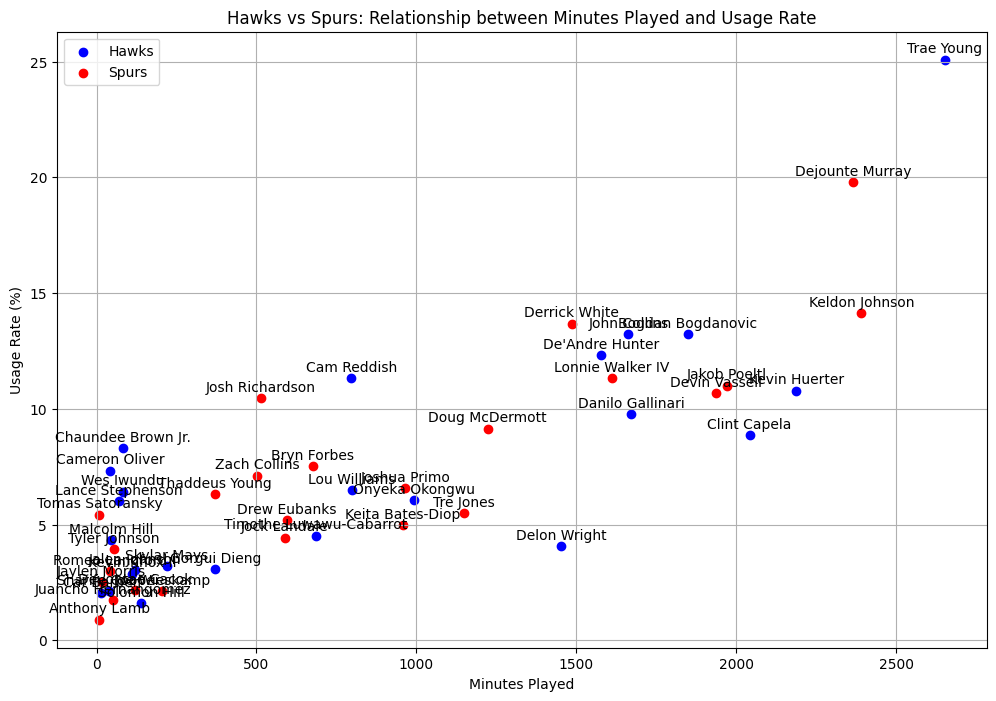

In [15]:
plt.figure(figsize=(12, 8))

# Plot Hawks data
plt.scatter(
    hawks_usage_df["Minutes Played"],
    hawks_usage_df["Usage Rate"],
    color="blue",
    label="Hawks",
)
for i in range(hawks_usage_df.shape[0]):
    plt.annotate(
        hawks_usage_df["Player"][i],
        (hawks_usage_df["Minutes Played"][i], hawks_usage_df["Usage Rate"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )

# Plot Spurs data
plt.scatter(
    spurs_usage_df["Minutes Played"],
    spurs_usage_df["Usage Rate"],
    color="red",
    label="Spurs",
)
for i in range(spurs_usage_df.shape[0]):
    plt.annotate(
        spurs_usage_df["Player"][i],
        (spurs_usage_df["Minutes Played"][i], spurs_usage_df["Usage Rate"][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
    )

plt.title("Hawks vs Spurs: Relationship between Minutes Played and Usage Rate")
plt.xlabel("Minutes Played")
plt.ylabel("Usage Rate (%)")
plt.grid(True)
plt.legend()

plt.show()

Now in analyzing this data, it would seem that with the more minuts a player plays, the higher their usage rate tends to be, which only makes sense in the grand scheme of their context. More likely than not, players who play more, tend to have higher impacts to their teams shot selection, teams turnovers and playmaking in general. In trying to look at Trae Young and Dejounte Murray, with more data across more seasons, I would run a linear regression model that would use Minutes played and along with the more consistent metrics (FTA, TO, FGA) that make up usage rate to predict how Trae and Dejounte would operate when playing together. 

To consider that we have the 2021-22 data to work with, lets just try it out to see how we can apply linear regression to this data, for example purposes, I am going to include minute played, FGA, TO and FGA in my model as features as I feel these most strongly determine the 

In [16]:
combined_usage_df = pd.concat([hawks_usage_df, spurs_usage_df], ignore_index=True)


# Define X (independent variable) and y (dependent variable)
X = combined_usage_df[["Minutes Played", "FGA", "TO", "FTA"]]  # Independent variable
y = combined_usage_df["Usage Rate"]  # Dependent variable (Usage Rate)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)

print(r2)
print(predictions)
# Example FGA, TO, FTA values for Trae Young and Dejounte Murray
trae_features = np.array(
    [[2652, 1544, 303, 553]]
)  # Minutes Played, FGA, TO, FTA for Trae Young
dejounte_features = np.array(
    [[2366, 1241, 180, 247]]
)  # Minutes Played, FGA, TO, FTA for Dejounte Murray

# Predict usage rates for Trae Young and Dejounte Murray based on all features
predicted_trae_usage = model.predict(trae_features)[0]
predicted_dejounte_usage = model.predict(dejounte_features)[0]

print(f"Predicted Usage Rate for Trae Young: {predicted_trae_usage:.2f}%")
print(f"Predicted Usage Rate for Dejounte Murray: {predicted_dejounte_usage:.2f}%")

0.8669215607207041
[13.57514745  4.15848499  8.740733    4.17947926 16.08793093  5.93564699
  3.87535147  3.9947939  10.24946125 10.50134931]
Predicted Usage Rate for Trae Young: 26.14%
Predicted Usage Rate for Dejounte Murray: 20.06%


Having an r2 score of .867 shows that the relationship between the input variable and the output variable holds a strong correlation.
As prediction data, I would most likely average out the last 5 years as parameters for both Trae and Dejounte but I decided to just use the supplied 2021-22 data as my prediction inputs.
My prediction for how each player would perform individually was actually that they would both decrease in usage rate as both hold similar on ball scoring abilities and would likely take away usage from one another. 

To start: 
- Trae Young Current USG: 25.08
- Predicted Trae Young USG: 26.14
- Dejounte Murray Current USG: 19.79
- Predicted Dejounte Murray USG: 20.06

Lets assume that the target usage rate will be the total of the expected usage which will be 26.14 + 20.06 = 46.20

now lets use the 21-22 usage rates as such 

In [17]:
trae_usage_rate = hawks_usage_df[hawks_usage_df["Player"] == "Trae Young"]["Usage Rate"].values[0]
dejounte_usage_rate = spurs_usage_df[spurs_usage_df["Player"] == "Dejounte Murray"][
    "Usage Rate"
].values[0]
target_combined_rate = 46.20

trae_proportion = trae_usage_rate / (trae_usage_rate + dejounte_usage_rate)
dejounte_proportion = dejounte_usage_rate / (trae_usage_rate + dejounte_usage_rate)


estimate_trae_usage = target_combined_rate * trae_proportion
estimate_dejounte_usage = target_combined_rate * dejounte_proportion

print("Estimated Trae Usage Rate with DeJounte: ", estimate_trae_usage)
print("Estimated Dejounte Murray Usage Rate: ", estimate_dejounte_usage)

Estimated Trae Usage Rate with DeJounte:  25.823632604032955
Estimated Dejounte Murray Usage Rate:  20.376367395967044


## Conclusion: 

There is a lot to be said about how to accurately calculate the usage rates of dejounte Murray and Trae Young following the trade that sent Dejounte Murray to the Hawks. A weakness of the study lies in the fact that we don't have the resources of past seasons to correlatae how the season total minutes, fga, to and fta contribute to the understanding of how they affect the influence on a players usage rate. Nonetheless we were able to calculate the usage rates of everyone on the Spurs and Hawks starting rosters to understand the team dynamic of the teams and as expected found that Dejounte Murray and Trae Young had the highest Usage Rates as they are the starting primary ball carriers for their respective teams. 

In further analyzing this question, I would analyze how Trae and Dejounte would benefit and negate from each others statistics, as both are bring the ball up the court type of players, it would seem Trae would start at PG while Dejounte Murray followed at SG and would play off each other and run the floor in a similar manner. So this would lead to 3 different scenarios 
- Trae Young and Dejounte both playing 
- Trae Yong playing while Dejounte sits 
- Dejounte playing while Trae sits 
the usage rates of both players in these situations would vary quite a bit and would be interesting to understand how each affect one another. In addition, I think something I could've explored is how each player plays with the top 6 players on their team in USG, I think that would've drawn a lot of insight on the understanding of how each players USG is while on the floor with the 2nd in USG and the 6th in USG. That difference could definitely be useful. 

I ended up using the Linear Regression model to predict the next seasons USG based on the current seasons data, but if given more information I would use the data from past seasons and their statistics to generate a more unbiased study, perhaps when each player played in similar situations as the proposed one. This produced an interesting statistic which is understandable but not entirely accurate to understanding the question 

Thus, I used the predicted USG as my expected estimate for their combined USG for the next season and wanted to understand how their current USG would be affected to calculate the new USG using the proportions of one another in their current situation and estimated that Trae would have a USG of 25.82 and Dejounte would have a USG of 20.38. 



### Sources 
- Provided Dataset 
- Basketball Reference: https://www.basketball-reference.com/ 
- StatMuse: https://www.statmuse.com/
- NBAStuffer: https://nbastuffer.com/
    